In [ ]:
import chess
from src.env.chess import ChessEnv
from src.agent.mcts_agent import MCTSAgent
import chess.pgn
import torch
from torch.utils.data import Dataset
import os

from src.agent.chess_dataset import ChessStockfishDataset

### Training of Neural Network for our MCTS

In [2]:
RESULT_MAP = {"1-0": 1, "0-1": -1, "1/2-1/2": 0}

In [3]:
def board_to_tensor(board):
    """Converts a python-chess board to a 8x8x12 tensor."""
    tensor = torch.zeros(12, 8, 8)
    piece_map = board.piece_map()
    for square, piece in piece_map.items():
        piece_type = piece.piece_type - 1  # 0–5
        color_offset = 0 if piece.color == chess.WHITE else 6
        row, col = divmod(square, 8)
        tensor[color_offset + piece_type, 7 - row, col] = 1
    return tensor

class ChessDataset(Dataset):
    def __init__(self, pgn_path, max_games=10000):
        self.data = []
        with open(pgn_path) as f:
            game = chess.pgn.read_game(f)
            count = 0
            while game and count < max_games:
                result = RESULT_MAP.get(game.headers["Result"])
                if result is not None:
                    board = game.board()
                    for move in game.mainline_moves():
                        state = board_to_tensor(board)
                        move_index = move_to_index(move)  # Defined below
                        self.data.append((state, move_index, result))
                        board.push(move)
                count += 1
                game = chess.pgn.read_game(f)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, move_idx, result = self.data[idx]
        return state, torch.tensor(move_idx), torch.tensor(result, dtype=torch.float32)
    
class CachedChessDataset(Dataset):
    def __init__(self, cache_dir):
        self.data = []
        if os.path.exists(cache_dir):
            with open(cache_dir, 'rb') as f:
                self.data = torch.load(f)
        else:
            raise FileNotFoundError(f"Cache file {cache_dir} does not exist.")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, move_idx, result = self.data[idx]
        return state, torch.tensor(move_idx), torch.tensor(result, dtype=torch.float32)

def move_to_index(move):
    """Maps a move to an index (simplified version)."""
    return move.from_square * 64 + move.to_square  # 0–4095

In [ ]:
from torch.utils.data import random_split, DataLoader

generator = torch.Generator().manual_seed(42) 

batch_size = 4096
dataset_path = "src/data/chess_dataset_normalized.pt"

# Load full dataset
dataset = CachedChessDataset(dataset_path)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)



C:\Users\Nizar\AppData\Local\Temp\ipykernel_22428\1639820129.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(f)


In [5]:
# Define split sizes
val_ratio = 0.1  # 10% validation
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

# Do the split
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [6]:
print(len(train_loader.dataset), len(val_loader.dataset))

550262 61140


In [7]:
import torch.nn as nn
    
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)



In [8]:
from tqdm import tqdm
from src.agent.model import AlphaGoNet, ChessNet

input_shape = (12, 8, 8)  # 12 channels for chess pieces, 8x8 board
output_shape = (4096, 1)  # 4096 possible moves
n_res_blocks = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_model(train_loader, val_loader, epochs=5, lr=1e-3, device=device):
    
    
    model = ChessNet().to(device)
    # model = AlphaGoNet(input_shape, output_shape, n_res_blocks).to(device)
    model.apply(init_weights)
    
    with torch.no_grad():
        policy, value = model(torch.randn(1, 12, 8, 8).to(device))
        print("Initial value:", value.item())
        print("Policy logits std:", policy.std().item())

    alpha_max = 1
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_policy = nn.CrossEntropyLoss()
    loss_value = nn.MSELoss()
    
    train_policy_losses = []
    train_value_losses = []
    val_policy_losses = []
    val_value_losses = []
    best_val_loss = float("inf")
    
    early_stop_counter = 0
    
    model.train()
    print("starting training...")
    for epoch in range(epochs):
        total_policy_loss = 0
        total_value_loss = 0
        
        total_policy_loss_val = 0
        total_value_loss_val = 0
        
        if epoch < 5:
                alpha = 0
        else:
            alpha = min( alpha_max, alpha_max * 2 * (1 - epoch / epochs ))
        
        for states, moves, values in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            
            states = states.to(device)
            moves = moves.to(device)
            values = values.to(device)
            
            optimizer.zero_grad()
            policy_logits, value_pred = model(states)

            loss_p = loss_policy(policy_logits, moves)
            loss_v = loss_value(value_pred.squeeze(), values)

            loss = alpha * loss_p + loss_v
            # print(loss.item())
            loss.backward()
            optimizer.step()

            total_policy_loss += loss_p.item()
            total_value_loss += loss_v.item()
            
        num_batches = len(train_loader)
        avg_policy_loss = total_policy_loss / num_batches
        avg_value_loss = total_value_loss / num_batches
        
        train_policy_losses.append(avg_policy_loss)
        train_value_losses.append(avg_value_loss)

        print(f"Epoch {epoch+1} | Avg Policy Loss: {avg_policy_loss:.4f}, Avg Value Loss: {avg_value_loss:.4f}")
        
        for states, moves, values in val_loader:
            states = states.to(device)
            moves = moves.to(device)
            values = values.to(device)

            with torch.no_grad():
                policy_logits, value_pred = model(states)

                loss_p = loss_policy(policy_logits, moves)
                loss_v = loss_value(value_pred.squeeze(), values)

                total_policy_loss_val += loss_p.item()
                total_value_loss_val += loss_v.item()
                
        num_batches = len(val_loader)
        avg_policy_loss = total_policy_loss_val / num_batches
        avg_value_loss = total_value_loss_val / num_batches
        
        val_policy_losses.append(avg_policy_loss)
        val_value_losses.append(avg_value_loss)
        
        print(f"Validation | Avg Policy Loss: {avg_policy_loss:.4f}, Avg Value Loss: {avg_value_loss:.4f}")
        
        # Save the model if validation loss improved
        avg_val_loss = avg_policy_loss + 10 * avg_value_loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), "best_model_0.pth")
            print(f"Model saved at epoch {epoch+1} with validation loss {avg_val_loss:.4f}")
            
            early_stop_counter = 0
            
        # If validation loss is not improving for 5 epochs, stop training
        else :
            early_stop_counter += 1
            if early_stop_counter >= 10:
                print("Early stopping triggered.")
                break
            
    all_losses = {
        "train_policy": train_policy_losses,
        "train_value": train_value_losses,
        "val_policy": val_policy_losses,
        "val_value": val_value_losses,
    }
    
    return model, all_losses

Using device: cuda


In [ ]:
model = train_model(train_loader, val_loader ,epochs=100, lr=1e-4, device=device)

Initial value: 0.8154364228248596
Policy logits std: 0.5678616166114807
starting training...


Epoch 1: 100%|██████████| 135/135 [00:12<00:00, 10.51it/s]


Epoch 1 | Avg Policy Loss: 8.4886, Avg Value Loss: 0.2714
Validation | Avg Policy Loss: 8.4871, Avg Value Loss: 0.1943
Model saved at epoch 1 with validation loss 10.4296


Epoch 2: 100%|██████████| 135/135 [00:11<00:00, 11.37it/s]


Epoch 2 | Avg Policy Loss: 8.4851, Avg Value Loss: 0.1783
Validation | Avg Policy Loss: 8.4845, Avg Value Loss: 0.1641
Model saved at epoch 2 with validation loss 10.1259


Epoch 3: 100%|██████████| 135/135 [00:12<00:00, 11.04it/s]


Epoch 3 | Avg Policy Loss: 8.4827, Avg Value Loss: 0.1593
Validation | Avg Policy Loss: 8.4828, Avg Value Loss: 0.1551
Model saved at epoch 3 with validation loss 10.0336


Epoch 4: 100%|██████████| 135/135 [00:12<00:00, 10.96it/s]


Epoch 4 | Avg Policy Loss: 8.4812, Avg Value Loss: 0.1507
Validation | Avg Policy Loss: 8.4816, Avg Value Loss: 0.1462
Model saved at epoch 4 with validation loss 9.9437


Epoch 5: 100%|██████████| 135/135 [00:11<00:00, 11.42it/s]


Epoch 5 | Avg Policy Loss: 8.4801, Avg Value Loss: 0.1448
Validation | Avg Policy Loss: 8.4808, Avg Value Loss: 0.1472


Epoch 6: 100%|██████████| 135/135 [00:11<00:00, 11.72it/s]


Epoch 6 | Avg Policy Loss: 5.9885, Avg Value Loss: 0.1431
Validation | Avg Policy Loss: 5.4278, Avg Value Loss: 0.1431
Model saved at epoch 6 with validation loss 6.8583


Epoch 7: 100%|██████████| 135/135 [00:12<00:00, 11.18it/s]


Epoch 7 | Avg Policy Loss: 5.0530, Avg Value Loss: 0.1456
Validation | Avg Policy Loss: 4.8862, Avg Value Loss: 0.1452
Model saved at epoch 7 with validation loss 6.3379


Epoch 8: 100%|██████████| 135/135 [00:12<00:00, 11.21it/s]


Epoch 8 | Avg Policy Loss: 4.5285, Avg Value Loss: 0.1468
Validation | Avg Policy Loss: 4.5088, Avg Value Loss: 0.1482
Model saved at epoch 8 with validation loss 5.9909


Epoch 9: 100%|██████████| 135/135 [00:12<00:00, 10.64it/s]


Epoch 9 | Avg Policy Loss: 4.1623, Avg Value Loss: 0.1459
Validation | Avg Policy Loss: 4.2644, Avg Value Loss: 0.1448
Model saved at epoch 9 with validation loss 5.7128


Epoch 10: 100%|██████████| 135/135 [00:13<00:00, 10.38it/s]


Epoch 10 | Avg Policy Loss: 3.9159, Avg Value Loss: 0.1452
Validation | Avg Policy Loss: 4.1092, Avg Value Loss: 0.1461
Model saved at epoch 10 with validation loss 5.5699


Epoch 11: 100%|██████████| 135/135 [00:12<00:00, 11.03it/s]


Epoch 11 | Avg Policy Loss: 3.7380, Avg Value Loss: 0.1409
Validation | Avg Policy Loss: 3.9998, Avg Value Loss: 0.1413
Model saved at epoch 11 with validation loss 5.4132


Epoch 12: 100%|██████████| 135/135 [00:11<00:00, 11.30it/s]


Epoch 12 | Avg Policy Loss: 3.6010, Avg Value Loss: 0.1387
Validation | Avg Policy Loss: 3.9189, Avg Value Loss: 0.1439
Model saved at epoch 12 with validation loss 5.3577


Epoch 13: 100%|██████████| 135/135 [00:12<00:00, 10.61it/s]


Epoch 13 | Avg Policy Loss: 3.4900, Avg Value Loss: 0.1384
Validation | Avg Policy Loss: 3.8567, Avg Value Loss: 0.1386
Model saved at epoch 13 with validation loss 5.2422


Epoch 14: 100%|██████████| 135/135 [00:12<00:00, 11.22it/s]


Epoch 14 | Avg Policy Loss: 3.3970, Avg Value Loss: 0.1343
Validation | Avg Policy Loss: 3.8085, Avg Value Loss: 0.1386
Model saved at epoch 14 with validation loss 5.1946


Epoch 15: 100%|██████████| 135/135 [00:11<00:00, 11.49it/s]


Epoch 15 | Avg Policy Loss: 3.3169, Avg Value Loss: 0.1331
Validation | Avg Policy Loss: 3.7699, Avg Value Loss: 0.1344
Model saved at epoch 15 with validation loss 5.1142


Epoch 16: 100%|██████████| 135/135 [00:11<00:00, 11.38it/s]


Epoch 16 | Avg Policy Loss: 3.2464, Avg Value Loss: 0.1304
Validation | Avg Policy Loss: 3.7380, Avg Value Loss: 0.1326
Model saved at epoch 16 with validation loss 5.0640


Epoch 17: 100%|██████████| 135/135 [00:12<00:00, 10.88it/s]


Epoch 17 | Avg Policy Loss: 3.1834, Avg Value Loss: 0.1287
Validation | Avg Policy Loss: 3.7115, Avg Value Loss: 0.1335
Model saved at epoch 17 with validation loss 5.0466


Epoch 18: 100%|██████████| 135/135 [00:12<00:00, 10.40it/s]


Epoch 18 | Avg Policy Loss: 3.1259, Avg Value Loss: 0.1278
Validation | Avg Policy Loss: 3.6883, Avg Value Loss: 0.1323
Model saved at epoch 18 with validation loss 5.0113


Epoch 19: 100%|██████████| 135/135 [00:11<00:00, 11.69it/s]


Epoch 19 | Avg Policy Loss: 3.0738, Avg Value Loss: 0.1247
Validation | Avg Policy Loss: 3.6688, Avg Value Loss: 0.1323
Model saved at epoch 19 with validation loss 4.9915


Epoch 20: 100%|██████████| 135/135 [00:11<00:00, 11.65it/s]


Epoch 20 | Avg Policy Loss: 3.0253, Avg Value Loss: 0.1237
Validation | Avg Policy Loss: 3.6527, Avg Value Loss: 0.1279
Model saved at epoch 20 with validation loss 4.9318


Epoch 21: 100%|██████████| 135/135 [00:11<00:00, 11.29it/s]


Epoch 21 | Avg Policy Loss: 2.9799, Avg Value Loss: 0.1222
Validation | Avg Policy Loss: 3.6414, Avg Value Loss: 0.1257
Model saved at epoch 21 with validation loss 4.8986


Epoch 22: 100%|██████████| 135/135 [00:11<00:00, 11.62it/s]


Epoch 22 | Avg Policy Loss: 2.9383, Avg Value Loss: 0.1199
Validation | Avg Policy Loss: 3.6298, Avg Value Loss: 0.1337


Epoch 23: 100%|██████████| 135/135 [00:14<00:00,  9.35it/s]


Epoch 23 | Avg Policy Loss: 2.8989, Avg Value Loss: 0.1196
Validation | Avg Policy Loss: 3.6199, Avg Value Loss: 0.1239
Model saved at epoch 23 with validation loss 4.8584


Epoch 24: 100%|██████████| 135/135 [00:12<00:00, 10.95it/s]


Epoch 24 | Avg Policy Loss: 2.8613, Avg Value Loss: 0.1167
Validation | Avg Policy Loss: 3.6119, Avg Value Loss: 0.1247


Epoch 25: 100%|██████████| 135/135 [00:12<00:00, 10.73it/s]


Epoch 25 | Avg Policy Loss: 2.8260, Avg Value Loss: 0.1165
Validation | Avg Policy Loss: 3.6053, Avg Value Loss: 0.1217
Model saved at epoch 25 with validation loss 4.8225


Epoch 26: 100%|██████████| 135/135 [00:12<00:00, 10.52it/s]


Epoch 26 | Avg Policy Loss: 2.7918, Avg Value Loss: 0.1144
Validation | Avg Policy Loss: 3.6018, Avg Value Loss: 0.1212
Model saved at epoch 26 with validation loss 4.8139


Epoch 27: 100%|██████████| 135/135 [00:12<00:00, 10.56it/s]


Epoch 27 | Avg Policy Loss: 2.7594, Avg Value Loss: 0.1139
Validation | Avg Policy Loss: 3.5967, Avg Value Loss: 0.1200
Model saved at epoch 27 with validation loss 4.7965


Epoch 28: 100%|██████████| 135/135 [00:10<00:00, 12.29it/s]


Epoch 28 | Avg Policy Loss: 2.7282, Avg Value Loss: 0.1109
Validation | Avg Policy Loss: 3.5934, Avg Value Loss: 0.1202
Model saved at epoch 28 with validation loss 4.7954


Epoch 29: 100%|██████████| 135/135 [00:11<00:00, 11.76it/s]


Epoch 29 | Avg Policy Loss: 2.6980, Avg Value Loss: 0.1108
Validation | Avg Policy Loss: 3.5902, Avg Value Loss: 0.1186
Model saved at epoch 29 with validation loss 4.7764


Epoch 30: 100%|██████████| 135/135 [00:11<00:00, 11.33it/s]


Epoch 30 | Avg Policy Loss: 2.6695, Avg Value Loss: 0.1095
Validation | Avg Policy Loss: 3.5890, Avg Value Loss: 0.1184
Model saved at epoch 30 with validation loss 4.7732


Epoch 31: 100%|██████████| 135/135 [00:11<00:00, 11.63it/s]


Epoch 31 | Avg Policy Loss: 2.6415, Avg Value Loss: 0.1078
Validation | Avg Policy Loss: 3.5901, Avg Value Loss: 0.1177
Model saved at epoch 31 with validation loss 4.7676


Epoch 32: 100%|██████████| 135/135 [00:11<00:00, 11.87it/s]


Epoch 32 | Avg Policy Loss: 2.6150, Avg Value Loss: 0.1068
Validation | Avg Policy Loss: 3.5889, Avg Value Loss: 0.1172
Model saved at epoch 32 with validation loss 4.7613


Epoch 33: 100%|██████████| 135/135 [00:11<00:00, 11.92it/s]


Epoch 33 | Avg Policy Loss: 2.5891, Avg Value Loss: 0.1060
Validation | Avg Policy Loss: 3.5897, Avg Value Loss: 0.1193


Epoch 34: 100%|██████████| 135/135 [00:11<00:00, 11.40it/s]


Epoch 34 | Avg Policy Loss: 2.5637, Avg Value Loss: 0.1055
Validation | Avg Policy Loss: 3.5910, Avg Value Loss: 0.1175


Epoch 35: 100%|██████████| 135/135 [00:12<00:00, 11.06it/s]


Epoch 35 | Avg Policy Loss: 2.5398, Avg Value Loss: 0.1042
Validation | Avg Policy Loss: 3.5910, Avg Value Loss: 0.1172


Epoch 36: 100%|██████████| 135/135 [00:11<00:00, 11.59it/s]


Epoch 36 | Avg Policy Loss: 2.5160, Avg Value Loss: 0.1025
Validation | Avg Policy Loss: 3.5941, Avg Value Loss: 0.1278


Epoch 37: 100%|██████████| 135/135 [00:11<00:00, 12.02it/s]


Epoch 37 | Avg Policy Loss: 2.4926, Avg Value Loss: 0.1038
Validation | Avg Policy Loss: 3.5968, Avg Value Loss: 0.1136
Model saved at epoch 37 with validation loss 4.7328


Epoch 38: 100%|██████████| 135/135 [00:12<00:00, 11.15it/s]


Epoch 38 | Avg Policy Loss: 2.4701, Avg Value Loss: 0.1000
Validation | Avg Policy Loss: 3.5994, Avg Value Loss: 0.1130
Model saved at epoch 38 with validation loss 4.7289


Epoch 39: 100%|██████████| 135/135 [00:11<00:00, 12.26it/s]


Epoch 39 | Avg Policy Loss: 2.4490, Avg Value Loss: 0.0994
Validation | Avg Policy Loss: 3.6032, Avg Value Loss: 0.1120
Model saved at epoch 39 with validation loss 4.7234


Epoch 40: 100%|██████████| 135/135 [00:12<00:00, 11.00it/s]


Epoch 40 | Avg Policy Loss: 2.4278, Avg Value Loss: 0.1004
Validation | Avg Policy Loss: 3.6069, Avg Value Loss: 0.1287


Epoch 41: 100%|██████████| 135/135 [00:10<00:00, 12.66it/s]


Epoch 41 | Avg Policy Loss: 2.4069, Avg Value Loss: 0.0983
Validation | Avg Policy Loss: 3.6114, Avg Value Loss: 0.1129


Epoch 42: 100%|██████████| 135/135 [00:10<00:00, 12.85it/s]


Epoch 42 | Avg Policy Loss: 2.3863, Avg Value Loss: 0.0983
Validation | Avg Policy Loss: 3.6167, Avg Value Loss: 0.1222


Epoch 43: 100%|██████████| 135/135 [00:10<00:00, 12.54it/s]


Epoch 43 | Avg Policy Loss: 2.3665, Avg Value Loss: 0.0978
Validation | Avg Policy Loss: 3.6205, Avg Value Loss: 0.1104


Epoch 44: 100%|██████████| 135/135 [00:10<00:00, 12.93it/s]


Epoch 44 | Avg Policy Loss: 2.3473, Avg Value Loss: 0.0954
Validation | Avg Policy Loss: 3.6285, Avg Value Loss: 0.1100


Epoch 45: 100%|██████████| 135/135 [00:10<00:00, 12.45it/s]


Epoch 45 | Avg Policy Loss: 2.3284, Avg Value Loss: 0.0959
Validation | Avg Policy Loss: 3.6326, Avg Value Loss: 0.1136


Epoch 46: 100%|██████████| 135/135 [00:11<00:00, 11.91it/s]


Epoch 46 | Avg Policy Loss: 2.3092, Avg Value Loss: 0.0945
Validation | Avg Policy Loss: 3.6393, Avg Value Loss: 0.1094


Epoch 47: 100%|██████████| 135/135 [00:12<00:00, 10.39it/s]


Epoch 47 | Avg Policy Loss: 2.2913, Avg Value Loss: 0.0945
Validation | Avg Policy Loss: 3.6434, Avg Value Loss: 0.1104


Epoch 48: 100%|██████████| 135/135 [00:10<00:00, 12.65it/s]


Epoch 48 | Avg Policy Loss: 2.2738, Avg Value Loss: 0.0924
Validation | Avg Policy Loss: 3.6513, Avg Value Loss: 0.1107


Epoch 49: 100%|██████████| 135/135 [00:11<00:00, 12.21it/s]


Epoch 49 | Avg Policy Loss: 2.2564, Avg Value Loss: 0.0936
Validation | Avg Policy Loss: 3.6572, Avg Value Loss: 0.1102
Early stopping triggered.


In [10]:
model, losses = model

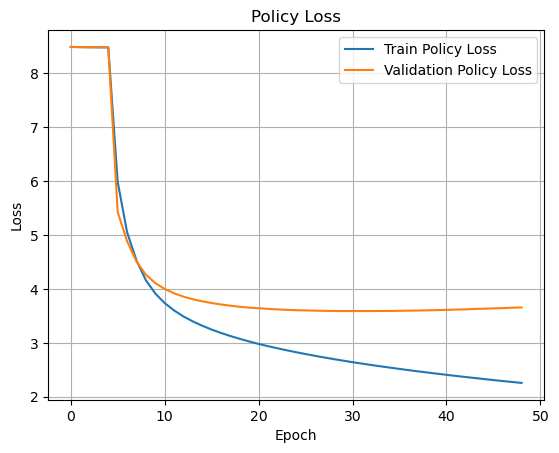

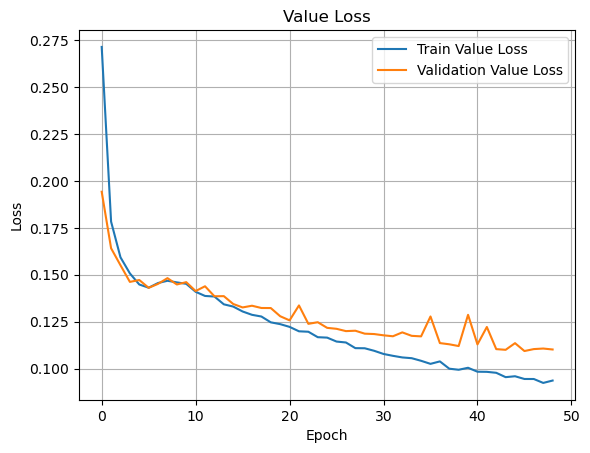

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses["train_policy"], label="Train Policy Loss")
plt.plot(losses["val_policy"], label="Validation Policy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Policy Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot value losses
plt.figure()
plt.plot(losses["train_value"], label="Train Value Loss")
plt.plot(losses["val_value"], label="Validation Value Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Value Loss")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
torch.save(model.state_dict(), "model.pth")